In [1]:
import collections
import os
import tempfile

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import urllib

import tensorflow as tf

from google.colab import files

In [2]:
# Definição de uma estrutura para armazenar informações sobre o dataset
DatasetInfo = collections.namedtuple(
    'DatasetInfo',
    'num_classes, label_divisor, thing_list, colormap, class_names')

# Função para gerar o colormap das classes do dataset Cityscapes
def _cityscapes_label_colormap():
    """
    Gera um mapeamento de cores para as classes do dataset Cityscapes.

    Retorno:
        np.ndarray: Array de tamanho (256, 3) contendo a cor RGB para cada classe.
    """
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]
    colormap[1] = [244, 35, 232]
    colormap[2] = [70, 70, 70]
    colormap[3] = [102, 102, 156]
    colormap[4] = [190, 153, 153]
    colormap[5] = [153, 153, 153]
    colormap[6] = [250, 170, 30]
    colormap[7] = [220, 220, 0]
    colormap[8] = [107, 142, 35]
    colormap[9] = [152, 251, 152]
    colormap[10] = [70, 130, 180]
    colormap[11] = [220, 20, 60]
    colormap[12] = [255, 0, 0]
    colormap[13] = [0, 0, 142]
    colormap[14] = [0, 0, 70]
    colormap[15] = [0, 60, 100]
    colormap[16] = [0, 80, 100]
    colormap[17] = [0, 0, 230]
    colormap[18] = [119, 11, 32]
    return colormap

# Função para retornar os nomes das classes do dataset Cityscapes
def _cityscapes_class_names():
    """
    Retorna os nomes das classes do dataset Cityscapes.

    Retorno:
        tuple: Tupla contendo os nomes das classes, como 'road', 'sidewalk', 'building', etc.
    """
    return ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
            'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
            'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
            'bicycle')

# Função para retornar as informações do dataset Cityscapes como um DatasetInfo
def cityscapes_dataset_information():
    """
    Retorna as informações do dataset Cityscapes organizadas em um DatasetInfo.

    Retorno:
        DatasetInfo: Uma instância de DatasetInfo com as informações do dataset Cityscapes.
    """
    return DatasetInfo(
        num_classes=19,
        label_divisor=1000,
        thing_list=tuple(range(11, 19)),
        colormap=_cityscapes_label_colormap(),
        class_names=_cityscapes_class_names())

# Função para perturbar uma cor (adicionar ruído) e garantir que seja única
def perturb_color(color, noise, used_colors, max_trials=50, random_state=None):
    """
    Perturba uma cor fornecida, aplicando um ruído aleatório, de forma que a nova cor não seja repetida
    em um conjunto de cores usadas.

    Parâmetros:
        color (np.ndarray): A cor base a ser perturbada (array de 3 valores RGB).
        noise (int): O nível de ruído para aplicar à cor.
        used_colors (set): Um conjunto das cores já utilizadas.
        max_trials (int): O número máximo de tentativas para encontrar uma cor única.
        random_state (np.random.RandomState): A semente para geração de números aleatórios.

    Retorno:
        np.ndarray: A cor aleatória gerada, perturbada e única.

    Exceção:
        Caso o número máximo de tentativas seja atingido, retorna a cor repetida.
    """
    if random_state is None:
        random_state = np.random

    for _ in range(max_trials):
        random_color = color + random_state.randint(
            low=-noise, high=noise + 1, size=3)
        random_color = np.clip(random_color, 0, 255)

        if tuple(random_color) not in used_colors:
            used_colors.add(tuple(random_color))
            return random_color

    print('Max trial reached and duplicate color will be used. Please consider '
          'increase noise in `perturb_color()`.')
    return random_color

# Função para gerar o mapa panóptico colorido a partir da previsão
def color_panoptic_map(panoptic_prediction, dataset_info, perturb_noise):
    """
    Gera um mapa de cores panópticas a partir das previsões panópticas de uma rede neural, aplicando
    cores específicas para cada instância e classe.

    Parâmetros:
        panoptic_prediction (np.ndarray): A previsão panóptica, que é uma matriz 2D com rótulos semânticos e de instâncias.
        dataset_info (DatasetInfo): Informações do dataset, como classes, divisor de rótulos e mapeamento de cores.
        perturb_noise (int): O nível de ruído a ser aplicado ao gerar cores únicas para as instâncias.

    Retorno:
        tuple: O mapa panóptico colorido e um dicionário de cores usadas.

    Exceção:
        Levanta um erro se a previsão panóptica não for uma matriz 2D.
    """
    if panoptic_prediction.ndim != 2:
        raise ValueError('Expect 2-D panoptic prediction. Got {}'.format(
            panoptic_prediction.shape))

    semantic_map = panoptic_prediction // dataset_info.label_divisor
    instance_map = panoptic_prediction % dataset_info.label_divisor
    height, width = panoptic_prediction.shape
    colored_panoptic_map = np.zeros((height, width, 3), dtype=np.uint8)

    used_colors = collections.defaultdict(set)

    random_state = np.random.RandomState(0)

    unique_semantic_ids = np.unique(semantic_map)
    for semantic_id in unique_semantic_ids:
        semantic_mask = semantic_map == semantic_id
        if semantic_id in dataset_info.thing_list:
            # Para classes "coisas", cria cores únicas para as instâncias
            unique_instance_ids = np.unique(instance_map[semantic_mask])
            for instance_id in unique_instance_ids:
                instance_mask = np.logical_and(semantic_mask,
                                               instance_map == instance_id)
                random_color = perturb_color(
                    dataset_info.colormap[semantic_id],
                    perturb_noise,
                    used_colors[semantic_id],
                    random_state=random_state)
                colored_panoptic_map[instance_mask] = random_color
        else:
            # Para classes "coisas", aplica a cor padrão
            colored_panoptic_map[semantic_mask] = dataset_info.colormap[semantic_id]
            used_colors[semantic_id].add(tuple(dataset_info.colormap[semantic_id]))

    return colored_panoptic_map, used_colors

# Função para visualizar a segmentação da imagem e o mapa panóptico
def vis_segmentation(image, panoptic_prediction, dataset_info, perturb_noise=60):
    """
    Visualiza a segmentação da imagem original e do mapa panóptico com sobreposição de cores.

    Parâmetros:
        image (np.ndarray): A imagem de entrada.
        panoptic_prediction (np.ndarray): As previsões panópticas para a segmentação.
        dataset_info (DatasetInfo): Informações do dataset.
        perturb_noise (int): O nível de ruído a ser aplicado ao gerar cores únicas para as instâncias.

    Exceção:
        Levanta um erro se a previsão panóptica não for uma matriz 2D.

    Exibe uma visualização com 4 subgráficos:
        1. A imagem original.
        2. O mapa panóptico colorido.
        3. A sobreposição do mapa panóptico na imagem original.
        4. Uma legenda das cores usadas para as instâncias e suas classes correspondentes.
    """
    plt.figure(figsize=(30, 20))
    grid_spec = gridspec.GridSpec(2, 2)

    ax = plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    ax.set_title('input image', fontsize=20)

    ax = plt.subplot(grid_spec[1])
    panoptic_map, used_colors = color_panoptic_map(panoptic_prediction,
                                                   dataset_info, perturb_noise)
    plt.imshow(panoptic_map)
    plt.axis('off')
    ax.set_title('panoptic map', fontsize=20)

    ax = plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(panoptic_map, alpha=0.7)
    plt.axis('off')
    ax.set_title('panoptic overlay', fontsize=20)

    ax = plt.subplot(grid_spec[3])
    max_num_instances = max(len(color) for color in used_colors.values())
    # Imagem RGBA para legenda.
    legend = np.zeros((len(used_colors), max_num_instances, 4), dtype=np.uint8)
    class_names = []
    for i, semantic_id in enumerate(sorted(used_colors)):
        legend[i, :len(used_colors[semantic_id]), :3] = np.array(
            list(used_colors[semantic_id]))
        legend[i, :len(used_colors[semantic_id]), 3] = 255
        if semantic_id < dataset_info.num_classes:
            class_names.append(dataset_info.class_names[semantic_id])
        else:
            class_names.append('ignore')

    plt.imshow(legend, interpolation='nearest')
    ax.yaxis.tick_left()
    plt.yticks(range(len(legend)), class_names, fontsize=15)
    plt.xticks([], [])
    ax.tick_params(width=0.0, grid_linewidth=0.0)
    plt.grid('off')
    plt.show()


In [3]:
# Definindo o nome do modelo a ser utilizado. O valor é escolhido de uma lista de modelos pré-configurados.
MODEL_NAME = 'resnet50_kmax_deeplab_cityscapes_train'  # @param ['resnet50_os32_panoptic_deeplab_cityscapes_crowd_trainfine_saved_model',
#            'resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model',
#            'wide_resnet41_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
#            'swidernet_sac_1_1_1_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
#            'swidernet_sac_1_1_3_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
#            'swidernet_sac_1_1_4.5_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
#            'axial_swidernet_1_1_1_os16_axial_deeplab_cityscapes_trainfine_saved_model',
#            'axial_swidernet_1_1_3_os16_axial_deeplab_cityscapes_trainfine_saved_model',
#            'axial_swidernet_1_1_4.5_os16_axial_deeplab_cityscapes_trainfine_saved_model',
#            'max_deeplab_s_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
#            'max_deeplab_l_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
#            'resnet50_kmax_deeplab_cityscapes_train',
#            'axial_resnet50_kmax_deeplab_cityscapes_train',
#            'convnext_tiny_kmax_deeplab_cityscapes_train',
#            'convnext_small_kmax_deeplab_cityscapes_train',
#            'convnext_base_kmax_deeplab_cityscapes_train',
#            'convnext_large_kmax_deeplab_cityscapes_train']

# Lista de modelos disponíveis para treinamento. Cada modelo é uma string que identifica uma configuração pré-definida.
_MODELS = (
    'resnet50_os32_panoptic_deeplab_cityscapes_crowd_trainfine_saved_model',
    'resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model',
    'wide_resnet41_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
    'swidernet_sac_1_1_1_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
    'swidernet_sac_1_1_3_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
    'swidernet_sac_1_1_4.5_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
    'axial_swidernet_1_1_1_os16_axial_deeplab_cityscapes_trainfine_saved_model',
    'axial_swidernet_1_1_3_os16_axial_deeplab_cityscapes_trainfine_saved_model',
    'axial_swidernet_1_1_4.5_os16_axial_deeplab_cityscapes_trainfine_saved_model',
    'max_deeplab_s_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
    'max_deeplab_l_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
    'resnet50_kmax_deeplab_cityscapes_train',
    'axial_resnet50_kmax_deeplab_cityscapes_train',
    'convnext_tiny_kmax_deeplab_cityscapes_train',
    'convnext_small_kmax_deeplab_cityscapes_train',
    'convnext_base_kmax_deeplab_cityscapes_train',
    'convnext_large_kmax_deeplab_cityscapes_train',
)

# Padrão de URL para download dos modelos, onde o nome do modelo será inserido na URL para buscar o arquivo correspondente.
_DOWNLOAD_URL_PATTERN = 'https://storage.googleapis.com/gresearch/tf-deeplab/saved_model/%s.tar.gz'

# Dicionário que mapeia o nome do modelo para a URL de download do modelo e as informações do conjunto de dados associado.
# Ele usa a função cityscapes_dataset_information() para fornecer as informações sobre o dataset.
_MODEL_NAME_TO_URL_AND_DATASET = {
    model: (_DOWNLOAD_URL_PATTERN % model, cityscapes_dataset_information())
    for model in _MODELS
}

# Obtém a URL de download e as informações do dataset com base no modelo selecionado.
MODEL_URL, DATASET_INFO = _MODEL_NAME_TO_URL_AND_DATASET[MODEL_NAME]


In [ ]:
# Cria um diretório temporário para armazenar os arquivos do modelo baixado.
model_dir = tempfile.mkdtemp()

# Define o caminho para onde o arquivo do modelo será baixado, incluindo o nome do modelo com a extensão '.gz'.
download_path = os.path.join(model_dir, MODEL_NAME + '.gz')

# Faz o download do arquivo compactado do modelo a partir da URL e o salva no diretório temporário.
urllib.request.urlretrieve(MODEL_URL, download_path)

# Extrai o arquivo compactado (.tar.gz) no diretório temporário criado anteriormente.
# Isso descompacta o conteúdo do modelo, tornando-o pronto para ser carregado.
!tar -xzvf {download_path} -C {model_dir}

# Carrega o modelo salvo no diretório temporário após a descompactação.
# O modelo é carregado usando a API tf.saved_model.load, permitindo que seja utilizado em inferências ou treinamentos.
LOADED_MODEL = tf.saved_model.load(os.path.join(model_dir, MODEL_NAME))


In [5]:
# Solicita o upload de arquivos através do widget de arquivos do Colab.
# A função `files.upload()` retorna um dicionário com os arquivos carregados.
uploaded = files.upload()

# Verifica se nenhum arquivo foi carregado e levanta um erro se não houver upload.
if not uploaded:
  raise AssertionError('Please upload one image')
# Verifica se apenas um arquivo foi carregado e seleciona esse arquivo.
elif len(uploaded) == 1:
  UPLOADED_FILE = list(uploaded.keys())[0]
# Se mais de um arquivo foi carregado, levanta um erro pedindo para carregar apenas um arquivo de cada vez.
else:
  raise AssertionError('Please upload one image at a time')


Saving bicycle-789648_640.jpg to bicycle-789648_640 (1).jpg


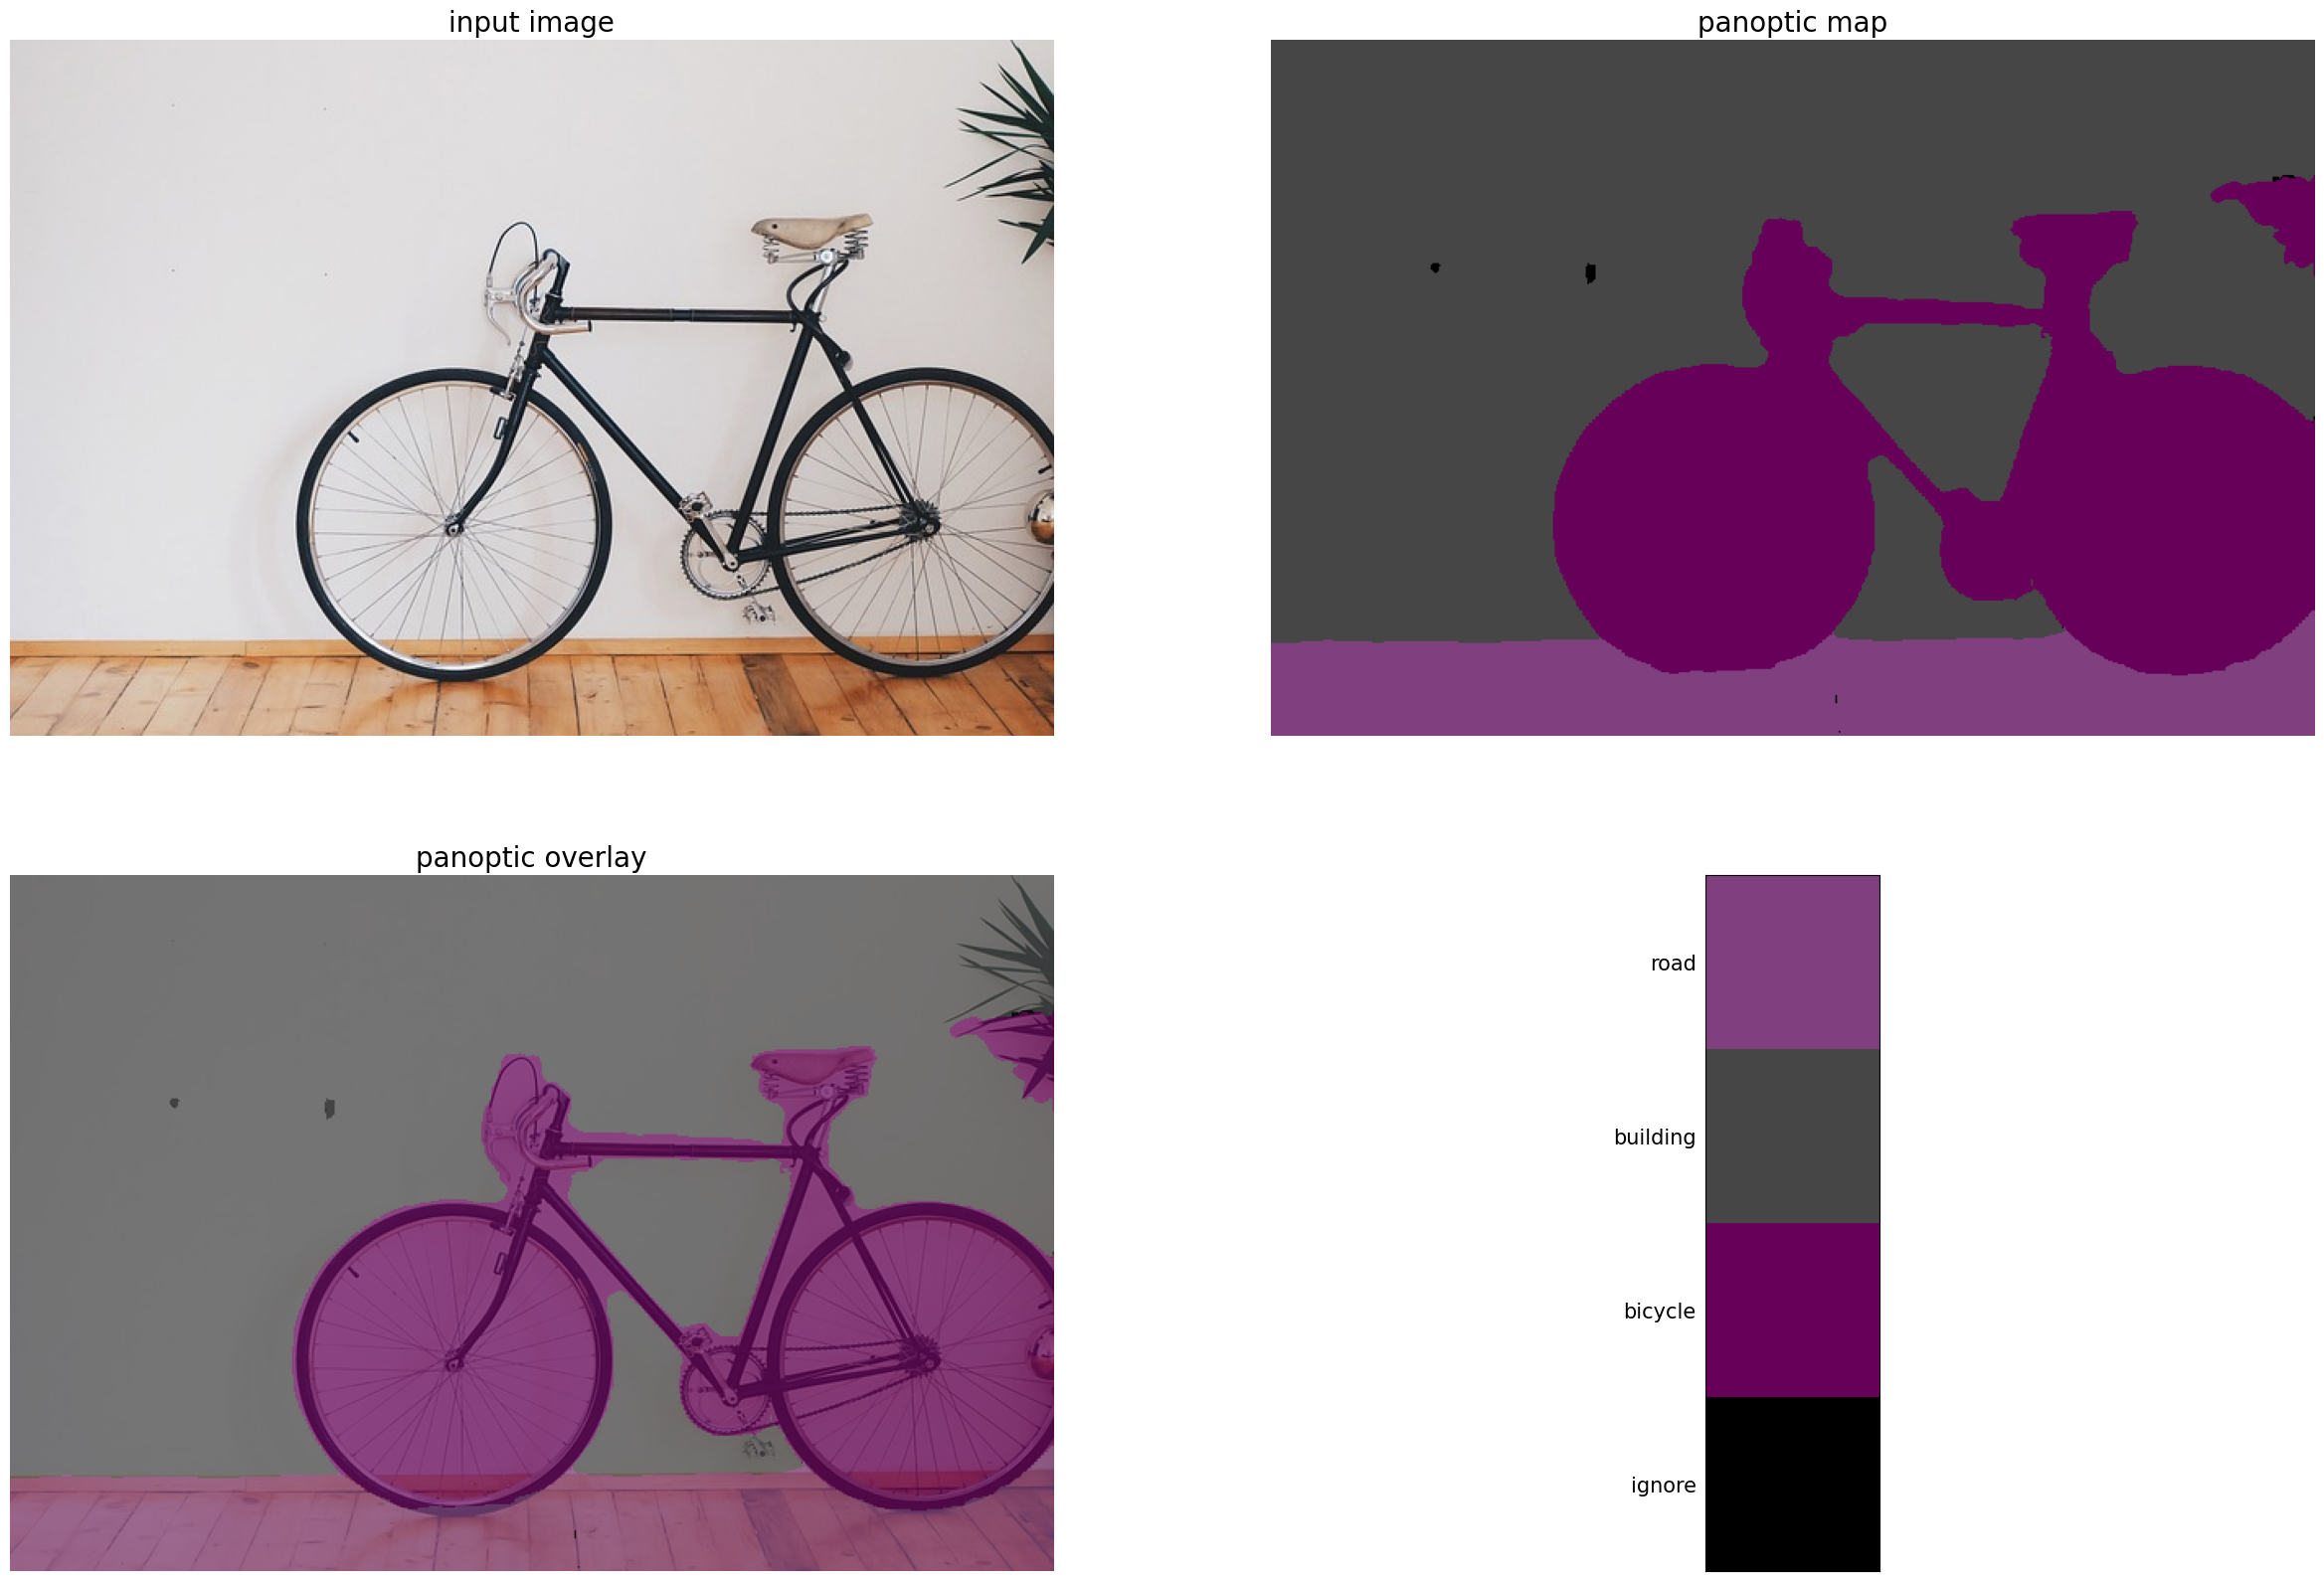

In [6]:
# Abre o arquivo de imagem carregado no modo binário ('rb') usando a API do TensorFlow.
# Utiliza tf.io.gfile.GFile para ler o arquivo de imagem no caminho especificado em UPLOADED_FILE.
with tf.io.gfile.GFile(UPLOADED_FILE, 'rb') as f:
  # Utiliza a biblioteca PIL (Python Imaging Library) para abrir a imagem e converte-a em um array NumPy.
  im = np.array(Image.open(f))

# Passa a imagem carregada e convertida para o modelo carregado (LOADED_MODEL) para obter a previsão.
# A imagem é convertida para o tipo de dado tf.uint8, adequado para a entrada do modelo.
output = LOADED_MODEL(tf.cast(im, tf.uint8))

# Exibe a segmentação gerada pelo modelo com a função vis_segmentation.
# Passa a imagem original, a predição panóptica (extraída do dicionário de saída do modelo),
# e as informações do dataset (DATASET_INFO) para visualização.
vis_segmentation(im, output['panoptic_pred'][0], DATASET_INFO)
